In [40]:
print("All ok")

All ok


In [44]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

import operator, os
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain.output_parsers import PydanticOutputParser

from langchain_community.document_loaders import TextLoader, DirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [42]:
# create model
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
output = model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [43]:
# create embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
len(embeddings.embed_query("hi"))

768

In [45]:
loader=DirectoryLoader("data",glob="./*.pdf",loader_cls=PyPDFLoader)
docs = loader.load()

In [46]:
docs[0]

Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, page_content="President of the Republic of India\nBhārata kē Rā ṣṭ rapati\nLogo of the President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince 25 July 2022\nHead of state of the Republic of India\nExecutive branch of the Indian Government\nStyle Hon'ble President\n(within India)[1]\nPresident of India\nThe president of India (ISO: Bhārata kē Rā ṣṭ rapati)\nis the head of state of the Republic of India. The\npresident is the nominal head of the executive,[a] the\nfirst citizen of the country, and the supreme\ncommander of the Indian Armed Forces. Droupadi\nMurmu is the 15th and current pres

In [47]:
## Get the source
docs[0].metadata["source"]

'data\\President_of_India.pdf'

In [48]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [49]:
new_docs=text_splitter.split_documents(documents=docs)
new_docs

[Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, page_content='President of the Republic of India\nBhārata kē Rā ṣṭ rapati\nLogo of the President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince 25 July 2022\nHead of state of the Republic of India'),
 Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, pag

In [50]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [51]:
class QuerySelectionParser(BaseModel):
    Query:str=Field(description="selected query")
    Reasoning:str=Field(description='Reasoning behind query selection')

In [52]:
parser=PydanticOutputParser(pydantic_object=QuerySelectionParser)

In [53]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Query": {"description": "selected query", "title": "Query", "type": "string"}, "Reasoning": {"description": "Reasoning behind query selection", "title": "Reasoning", "type": "string"}}, "required": ["Query", "Reasoning"]}\n```'

In [54]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [57]:
def Supervisor(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Related to President of India, Not Related to President of India]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Query]}

In [58]:
state1={"messages":["who is the president?"]}
Supervisor(state1)

Question who is the president?
Parsed response: Query='Related to President of India' Reasoning='The query "who is the president?" is ambiguous but can refer to the President of India.  Without further context, it is the most likely interpretation.'


{'messages': ['Related to President of India']}

In [59]:
state2 = {"messages":["who is Narendra Modi?"]}
Supervisor(state2)

Question who is Narendra Modi?
Parsed response: Query='Not Related to President of India' Reasoning='Narendra Modi is the Prime Minister of India, not the President.'


{'messages': ['Not Related to President of India']}

In [60]:
def Router(state: AgentState):
    print("->ROUTER->")
    last_message = state["messages"][-1]
    print("last_message:", last_message)

    if "president of india" in last_message.lower():
        return "RAG Call"
    elif "not related" in last_message.lower():
        return "LLM Call"
    elif "web" in last_message.lower():
        return "WEB Call"
    else:
        return "LLM Call"

In [61]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [62]:
def RAG(state:AgentState):
    print("->RAG Call->")
    question=state["messages"][-1]
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    rag_chain=(
        {"context":retriever|format_docs,"question":RunnablePassthrough()}|prompt|model|StrOutputParser()
    )
    result=rag_chain.invoke(question)
    return {"messages":[result]}

In [63]:
def LLM(state: AgentState):
    print("->LLM Call->")
    question=state["messages"][0]
    complete_query="Answer the following question with your knowledge of the real world . Following is the user question: "+question
    response=model.invoke(complete_query)
    return {"messages":[response]}

In [64]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api_key = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearchResults(tavily_api_key=tavily_api_key)

tavily_tool.invoke({"query": "What happened in RCB victory parade?"})

[{'title': '11 Dead In RCB Victory Parade Stampede - YouTube',
  'url': 'https://www.youtube.com/watch?v=kgwctnQYZIM',
  'content': "India Today\n26 likes\n4809 views\n5 Jun 2025\nA stampede at the Royal Challengers Bangaluru (RCB) victory parade resulted in 11 deaths. Sources reveal that police had warned against holding the event on a weekday and had not given permission. RCB announced the parade and free entry without police consultation, leading to a massive crowd of nearly 8 lakh people overwhelming the 1,000 deployed policemen. The event's organization and lack of proper permissions are now under scrutiny.",
  'score': 0.86981434},
 {'title': 'RCB victory parade stampede updates: Bengaluru city chief B ...',
  'url': 'https://www.thehindu.com/news/national/rcb-ipl-victory-parade-stampede-death-toll-virat-kohli-chinnaswamy-stadium-live/article69656707.ece',
  'content': 'A stampede that broke out near the Chinnaswamy stadium in Bengaluru, after fans gathered to celebrate Royal Cha

In [65]:
def WEB(state: AgentState):
    print("->WEB Call->")
    question = state["messages"][0]

    result=tavily_tool.invoke({"query":question})

    return {"messages":[result[0]["content"]]}
    

In [67]:
def Validator(state:AgentState):
    print("->Validator->")
    ans=state["messages"][-1].lower()
    if "i don't know" in ans or len(ans.strip()) < 10:
        return {"messages":["retry"]}
    
    return {"messages":[ans]}

In [68]:
def retryRouter(state: AgentState):
    print("->IN RETRY ROUTER->")

    msg = state["messages"][-1]
    if msg == "retry":
        return "Supervisor"
    return "Final"

In [69]:
def finalNode(state:AgentState):
    print("->IN Final Node->")
    return {"messages": [f"✅ Final Answer: {state['messages'][-1]}"]}

In [70]:
workflow=StateGraph(AgentState)

In [71]:
workflow.add_node("Supervisor",Supervisor)
workflow.add_node("RAG",RAG)
workflow.add_node("LLM",LLM)
workflow.add_node("WEB",WEB)
workflow.add_node("Validator",Validator)
workflow.add_node("Final",finalNode)

In [72]:
workflow.set_entry_point("Supervisor")

In [73]:
workflow.add_conditional_edges(
    "Supervisor",
    Router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WEB Call": "WEB"
    }
)

In [74]:
workflow.add_edge("RAG","Validator")
workflow.add_edge("LLM","Validator")
workflow.add_edge("WEB","Validator")

In [75]:
workflow.add_conditional_edges(
    "Validator",
    retryRouter,
    {
        "Supervisor": "Supervisor",
        "Final": "Final"
    }
)

In [76]:
workflow.add_edge("Final",END)

In [77]:
app = workflow.compile()

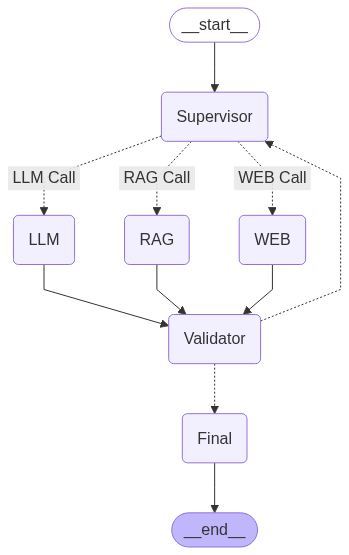

In [78]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [79]:
state = {"messages":["Hi!"]}

In [80]:
state = {"messages":["From Web tell me about RCB"]}

In [81]:
app.invoke(state)

Question From Web tell me about RCB
Parsed response: Query='From Web tell me about RCB' Reasoning='RCB is likely a reference to the Royal Challengers Bangalore cricket team, which is not related to the President of India.'
->ROUTER->
last_message: From Web tell me about RCB
->WEB Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['From Web tell me about RCB',
  'From Web tell me about RCB',
  '**Royal Challengers Bengaluru**, formerly known as **Royal Challengers Bangalore**, commonly known as **RCB**, is a professional [franchise cricket](https://en.wikipedia.org/wiki/Cricket "Cricket") team based in [Bengaluru](https://en.wikipedia.org/wiki/Bengaluru "Bengaluru"), [Karnataka](https://en.wikipedia.org/wiki/Karnataka "Karnataka"), competing in the [Indian Premier League](https://en.wikipedia.org/wiki/Indian_Premier_League "Indian Premier League"). Founded in 2008 by [United [...] Spirits](https://en.wikipedia.org/wiki/United_Spirits "United Spirits"), currently managed by Prathamesh Mishra, the team is named after the liquor brand, [Royal Challenge](https://en.wikipedia.org/wiki/Royal_Challenge "Royal Challenge"). The [M. Chinnaswamy Stadium](https://en.wikipedia.org/wiki/M._Chinnaswamy_Stadium "M. Chinnaswamy Stadium") in Bengaluru is their home ground. It is the most popular and followed cricket

In [84]:
state1={"messages":["Hi! my name is Gaurav can you tell me today's weather in Bangalore from web?"]}

app.invoke(state1)

Question Hi! my name is Gaurav can you tell me today's weather in Bangalore from web?
Parsed response: Query='Not Related to President of India' Reasoning='The query is a request for weather information, unrelated to the President of India.'
->ROUTER->
last_message: Not Related to President of India
->RAG Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ["Hi! my name is Gaurav can you tell me today's weather in Bangalore from web?",
  'Not Related to President of India',
  'The provided text focuses on the President of India, including their role, list of past presidents, and spouse.  Therefore, the question "Not Related to President of India" cannot be answered using this context.  There is no information unrelated to the President of India in the given text.',
  'the provided text focuses on the president of india, including their role, list of past presidents, and spouse.  therefore, the question "not related to president of india" cannot be answered using this context.  there is no information unrelated to the president of india in the given text.',
  '✅ Final Answer: the provided text focuses on the president of india, including their role, list of past presidents, and spouse.  therefore, the question "not related to president of india" cannot be answered using this context.  there is no information unrelated to the 

In [85]:
state1={"messages":["How president is elected in India?"]}
state2 = {"messages": ["what is the latest news on RCB?"]}
state3 = {"messages": ["Did KKR victory parade took place?, and how many times KKR won IPL?"]}
state4 = {"messages": ["Who is the current president, is it a he or she and when it got elected?"]}
state5 = {"messages": ["What is Machine Learning and its types?"]}

In [86]:
result = app.invoke(state1)
result

Question How president is elected in India?
Parsed response: Query='Related to President of India' Reasoning='The query explicitly asks about the election process of the President of India.'
->ROUTER->
last_message: Related to President of India
->RAG Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['How president is elected in India?',
  'Related to President of India',
  'The President of India is the Head of State of the Republic of India and part of the executive branch of the Indian government.  The title is styled as "Hon\'ble President" within India.  The Indian constitution outlines the President\'s powers.',
  'the president of india is the head of state of the republic of india and part of the executive branch of the indian government.  the title is styled as "hon\'ble president" within india.  the indian constitution outlines the president\'s powers.',
  '✅ Final Answer: the president of india is the head of state of the republic of india and part of the executive branch of the indian government.  the title is styled as "hon\'ble president" within india.  the indian constitution outlines the president\'s powers.']}

In [87]:
result = app.invoke(state2)
result

Question what is the latest news on RCB?
Parsed response: Query='Not Related to President of India' Reasoning='The query is about RCB (Royal Challengers Bangalore), a cricket team, which is unrelated to the President of India.'
->ROUTER->
last_message: Not Related to President of India
->RAG Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['what is the latest news on RCB?',
  'Not Related to President of India',
  'The provided text focuses on the President of India, including their role and a list of past presidents.  Therefore,  the question "Not Related to President of India" cannot be answered using this context.',
  'the provided text focuses on the president of india, including their role and a list of past presidents.  therefore,  the question "not related to president of india" cannot be answered using this context.',
  '✅ Final Answer: the provided text focuses on the president of india, including their role and a list of past presidents.  therefore,  the question "not related to president of india" cannot be answered using this context.']}

In [88]:
result = app.invoke(state3)
result

Question Did KKR victory parade took place?, and how many times KKR won IPL?
Parsed response: Query='Not Related to President of India' Reasoning='The query is about Kolkata Knight Riders (KKR), an IPL cricket team, and their victories.  It has no relation to the President of India.'
->ROUTER->
last_message: Not Related to President of India
->RAG Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['Did KKR victory parade took place?, and how many times KKR won IPL?',
  'Not Related to President of India',
  'The provided text focuses on the President of India.  It includes a list of presidents and mentions their role as head of the executive.  Therefore, the question is unrelated to the provided context.',
  'the provided text focuses on the president of india.  it includes a list of presidents and mentions their role as head of the executive.  therefore, the question is unrelated to the provided context.',
  '✅ Final Answer: the provided text focuses on the president of india.  it includes a list of presidents and mentions their role as head of the executive.  therefore, the question is unrelated to the provided context.']}

In [89]:
result = app.invoke(state4)
result

Question Who is the current president, is it a he or she and when it got elected?
Parsed response: Query='Related to President of India' Reasoning='The query explicitly asks about the current president, their gender, and election date, all of which are directly related to the office of the President of India.'
->ROUTER->
last_message: Related to President of India
->RAG Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['Who is the current president, is it a he or she and when it got elected?',
  'Related to President of India',
  'The President of India is the Head of State of the Republic of India and part of the Executive branch of the Indian government.  The President\'s formal title is "Hon\'ble President".  The Indian constitution defines the President\'s powers.',
  'the president of india is the head of state of the republic of india and part of the executive branch of the indian government.  the president\'s formal title is "hon\'ble president".  the indian constitution defines the president\'s powers.',
  '✅ Final Answer: the president of india is the head of state of the republic of india and part of the executive branch of the indian government.  the president\'s formal title is "hon\'ble president".  the indian constitution defines the president\'s powers.']}